In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download msambare/fer2013

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile
zip_ref = zipfile.ZipFile("/content/fer2013.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


In [8]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [9]:
TRAIN_DIR='/content/train'
TEST_DIR='/content/test'

In [10]:

def createDataFrame(dir):
    image_paths = []
    labels = []

    for label in os.listdir(dir):
        label_dir = os.path.join(dir, label)
        for imagename in os.listdir(label_dir):
            image_paths.append(os.path.join(label_dir, imagename))
            labels.append(label)

        print(f"{label} completed")

    return image_paths, labels

In [11]:
train=pd.DataFrame()
train['image'],train['label']=createDataFrame(TRAIN_DIR)

happy completed
neutral completed
disgust completed
fear completed
angry completed
surprise completed
sad completed


In [12]:
print(train)


                                            image  label
0       /content/train/happy/Training_3723238.jpg  happy
1      /content/train/happy/Training_12558365.jpg  happy
2       /content/train/happy/Training_5729449.jpg  happy
3      /content/train/happy/Training_61263386.jpg  happy
4      /content/train/happy/Training_80485124.jpg  happy
...                                           ...    ...
28704    /content/train/sad/Training_53938028.jpg    sad
28705    /content/train/sad/Training_30538297.jpg    sad
28706      /content/train/sad/Training_887025.jpg    sad
28707    /content/train/sad/Training_80017807.jpg    sad
28708    /content/train/sad/Training_42889396.jpg    sad

[28709 rows x 2 columns]


In [13]:
test=pd.DataFrame()
test['image'],test['label']=createDataFrame(TEST_DIR)

happy completed
neutral completed
disgust completed
fear completed
angry completed
surprise completed
sad completed


In [14]:
print(test)
print(test['image'])


                                             image  label
0      /content/test/happy/PublicTest_28340669.jpg  happy
1       /content/test/happy/PublicTest_4611414.jpg  happy
2     /content/test/happy/PrivateTest_25072457.jpg  happy
3      /content/test/happy/PublicTest_80906126.jpg  happy
4      /content/test/happy/PublicTest_39688575.jpg  happy
...                                            ...    ...
7173     /content/test/sad/PublicTest_78074054.jpg    sad
7174      /content/test/sad/PrivateTest_831970.jpg    sad
7175     /content/test/sad/PublicTest_50152754.jpg    sad
7176     /content/test/sad/PublicTest_33151772.jpg    sad
7177     /content/test/sad/PublicTest_69378300.jpg    sad

[7178 rows x 2 columns]
0        /content/test/happy/PublicTest_28340669.jpg
1         /content/test/happy/PublicTest_4611414.jpg
2       /content/test/happy/PrivateTest_25072457.jpg
3        /content/test/happy/PublicTest_80906126.jpg
4        /content/test/happy/PublicTest_39688575.jpg
              

In [15]:
test=pd.DataFrame()
test['image'],test['label']=createDataFrame(TEST_DIR)

happy completed
neutral completed
disgust completed
fear completed
angry completed
surprise completed
sad completed


In [16]:
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D


In [17]:

def extractFeatures(images):
    features=[]
    for images in tqdm(images):
         img = load_img(images, color_mode="grayscale")
         img=np.array(img)
         features.append(img)
    features=np.array(features)
    features=features.reshape(len(features),48,48,1)
    return features

In [18]:
train_features=extractFeatures(train['image'])

100%|██████████| 28709/28709 [00:04<00:00, 6293.90it/s]


In [ ]:
test_features=extractFeatures(test['image'])


100%|██████████| 7178/7178 [00:00<00:00, 7873.74it/s]


In [20]:
x_train=train_features/255.0
x_test=test_features/255.0

In [21]:
from sklearn.preprocessing import LabelEncoder


In [22]:
le=LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [23]:
y_train=le.transform(train['label'])
y_test=le.transform(test['label'])

In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [25]:
model=Sequential()
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(7, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:

history=model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 33s 92ms/step - accuracy: 0.2330 - loss: 1.8391 - val_accuracy: 0.2471 - val_loss: 1.8135
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.2550 - loss: 1.8119 - val_accuracy: 0.2856 - val_loss: 1.7368
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.2837 - loss: 1.7362 - val_accuracy: 0.3200 - val_loss: 1.6485
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.3396 - loss: 1.6494 - val_accuracy: 0.4401 - val_loss: 1.4628
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.4038 - loss: 1.5210 - val_accuracy: 0.4791 - val_loss: 1.3664
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.4364 - loss: 1.4499 - val_accuracy: 0.4890 - val_loss: 1.3299
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.4611 - loss: 1.3948 - val_accuracy: 0.4994 - val_loss: 1.2935
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.4771 - loss: 1

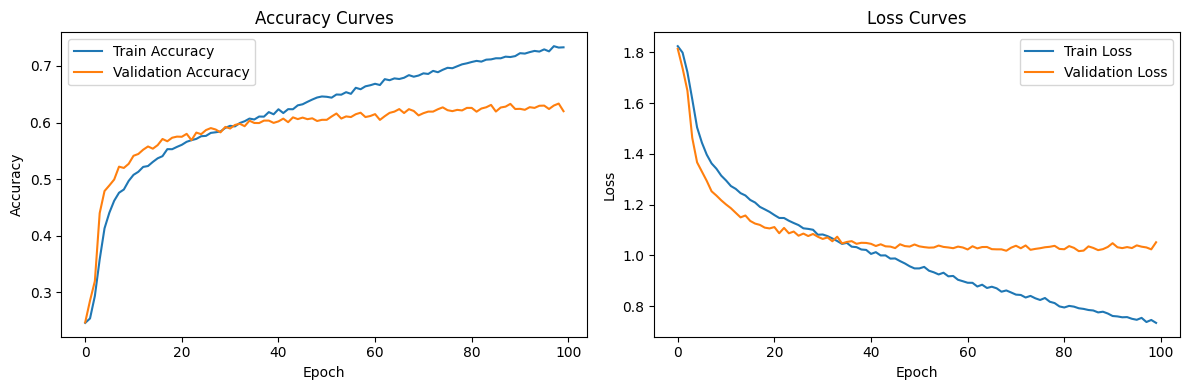

In [28]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Save model
model.save('facial_expressionss.h5')

In [31]:
from google.colab import files
files.download('facial_expressionss.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
# Save model architecture to a JSON file
model_json = model.to_json()

# Save the architecture to a file
with open("emotiondetectorss.json", "w") as json_file:
    json_file.write(model_json)


In [33]:
files.download("emotiondetectorss.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>